In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from tqdm import tqdm

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHT_PATH = "weights"
RECORD_PATH = "records"
os.makedirs(WEIGHT_PATH, exist_ok=True)
os.makedirs(RECORD_PATH, exist_ok=True)

In [2]:
transform_eval = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
    ]
)

testset = ImageFolder("birds-400/test", transform=transform_eval)

model = resnet50()

model.fc = torch.nn.Linear(2048, len(testset.class_to_idx))

model.load_state_dict(torch.load(os.path.join(WEIGHT_PATH, "r50_simclr_finetune.pt")))

model = model.to(device)

testloader = torch.utils.data.DataLoader(testset, 32, pin_memory=True)
criterion = torch.nn.CrossEntropyLoss()

In [3]:
metric = defaultdict(list)
pbar = tqdm(total=len(testloader))

model.eval()
for i, (inputs, targets) in enumerate(testloader, 1):
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.inference_mode():
        outputs = model(inputs)
        loss = criterion(outputs, targets)

    metric["test_loss"].append(loss.item())
    metric["test_accuracy"].append(
        (outputs.argmax(-1) == targets).float().mean().item()
    )
    pbar.set_postfix({k: np.mean(v) for k, v in metric.items()})
    pbar.update()
pbar.close()

100%|██████████| 63/63 [00:05<00:00, 11.94it/s, test_loss=1.84, test_accuracy=0.566]


In [4]:
history_pretrain = torch.load(os.path.join(RECORD_PATH, "r50_simclr_pretrain.pt"))
history_finetune = torch.load(os.path.join(RECORD_PATH, "r50_simclr_finetune.pt"))

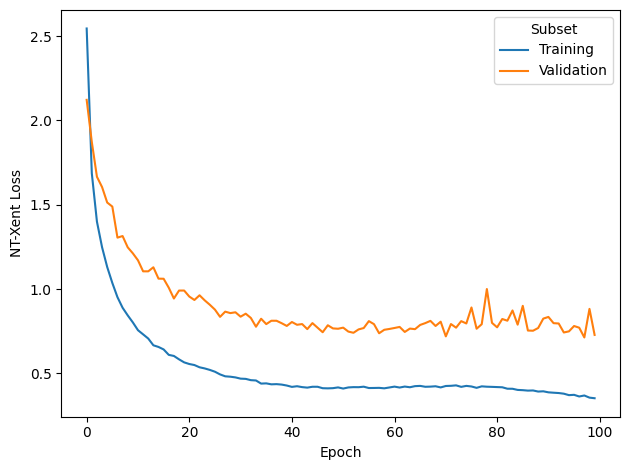

In [5]:
pretrain_loss_train = [metric["train_loss"] for metric in history_pretrain]
pretrain_loss_valid = [metric["valid_loss"] for metric in history_pretrain]

plt.plot(pretrain_loss_train, label="Training")
plt.plot(pretrain_loss_valid, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.legend(title="Subset")
plt.tight_layout()

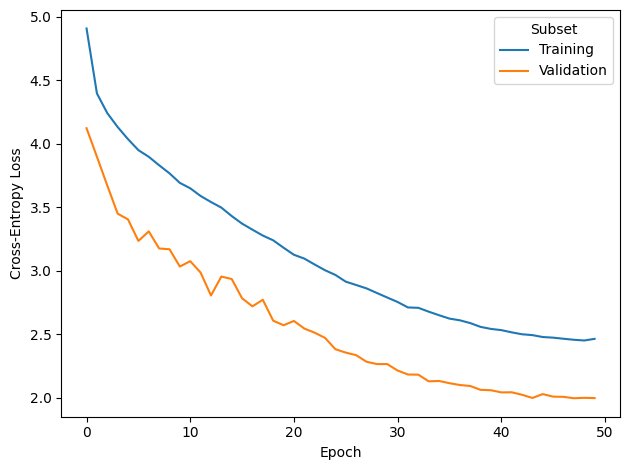

In [6]:
finetune_loss_train = [metric["train_loss"] for metric in history_finetune]
finetune_loss_valid = [metric["valid_loss"] for metric in history_finetune]

plt.plot(finetune_loss_train, label="Training")
plt.plot(finetune_loss_valid, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend(title="Subset")
plt.tight_layout()

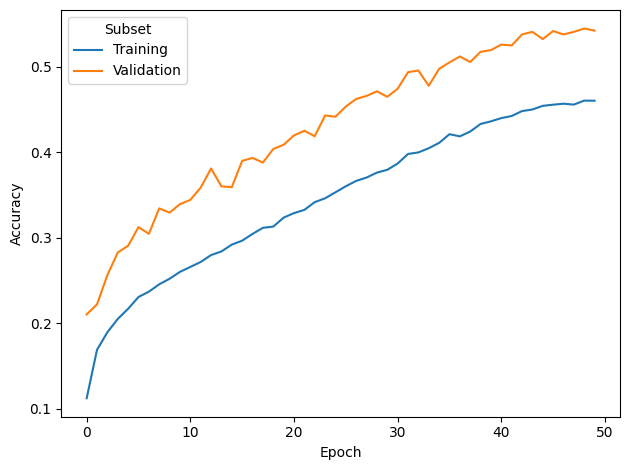

In [7]:
finetune_accuracy_train = [metric["train_accuracy"] for metric in history_finetune]
finetune_accuracy_valid = [metric["valid_accuracy"] for metric in history_finetune]

plt.plot(finetune_accuracy_train, label="Training")
plt.plot(finetune_accuracy_valid, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Subset")
plt.tight_layout()